# **Carga de dataset**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="yEfEDr5d0p7hkCqFa1QE")
project = rf.workspace("fernan22").project("retinopatia-diabetica-75nfo")
version = project.version(3)
dataset = version.download("multiclass")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Retinopatía-Diabética-3 in multiclass:: 100%|██████████| 4849/4849 [00:00<00:00, 5612.91it/s]


In [ ]:
import os
print(os.listdir('/content/Retinopatía-Diabética-3/train'))

['DR131_jpg.rf.a938e2983925e8b038d845c2757e3aba.jpg', 'DR1505_jpg.rf.446edb3682b3fb5c5d5e6ec5d8ed905a.jpg', 'DR307_jpg.rf.20db676d3ce4611f26d61f954e719204.jpg', 'Healthy148_jpg.rf.8c9166229f288d4fe08ab86baab83609.jpg', 'Healthy206_jpg.rf.26eacceb63192dec5057dbf9bd0d8748.jpg', 'DR614_jpg.rf.edfb6822ced5f1a5fac5e6b871d3fed0.jpg', 'DR1162_jpg.rf.c0ddca3ff82151d09b86e3e8b5b4533c.jpg', 'Healthy980_jpg.rf.bf2dec8624209e172c7dd37907269306.jpg', 'DR1438_jpg.rf.86dfaddc15899385563ad8eee225540b.jpg', 'DR1248_jpg.rf.b479e136ce430dc17171b499ed9cb9cd.jpg', 'Healthy644_jpg.rf.6b612c14afe57e930f2c0576ec680f6b.jpg', 'DR829_jpg.rf.a530c1e2384e2bea6e535b899b393ba4.jpg', 'Healthy276_jpg.rf.3ae00ce1f7f28f020b2c127cd8d8c024.jpg', 'Healthy684_jpg.rf.7e5a158e3c11d72d43bd067ddef24cff.jpg', 'Healthy638_jpg.rf.b8dfd21a4369256c18ca327b84453f17.jpg', 'DR200_jpg.rf.f1914d088c9f272ee5ef6d3daf3eec9d.jpg', 'Healthy923_jpg.rf.094709273d203a99ea778ca815505d7c.jpg', 'Healthy756_jpg.rf.e75365d2a2c564347c64218affe17f39.jp

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class RetinopathyDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        # Limpiamos los nombres de las columnas para evitar errores de espacios
        self.annotations.columns = self.annotations.columns.str.strip()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0] # Nombre de la imagen
        img_path = os.path.join(self.img_dir, img_id)
        image = Image.open(img_path).convert("RGB")

        # Obtenemos la etiqueta (0 para sano, 1 para retinopatía)
        # Asumiendo que las columnas son: filename, Healthy, Retinopathy
        y_label = torch.tensor(float(self.annotations.iloc[index, 2]))

        if self.transform:
            image = self.transform(image)

        return image, y_label

# Definir las transformaciones para las imágenes
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Configurar rutas y cargadores
data_dir = '/content/Retinopatía-Diabética-3'

image_datasets = {
    'train': RetinopathyDataset(f"{data_dir}/train/_classes.csv", f"{data_dir}/train", data_transforms['train']),
    'val': RetinopathyDataset(f"{data_dir}/valid/_classes.csv", f"{data_dir}/valid", data_transforms['val']),
    'test': RetinopathyDataset(f"{data_dir}/test/_classes.csv", f"{data_dir}/test", data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
}

print(f"Éxito: {len(image_datasets['train'])} imágenes cargadas correctamente.")

Éxito: 4245 imágenes cargadas correctamente.


In [ ]:
import time
import copy
from sklearn.metrics import precision_score, recall_score, f1_score

def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Diccionario para guardar historial y graficar después
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).long() # Aseguramos que las etiquetas sean long para CrossEntropy

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Entrenamiento completo en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Mejor Accuracy en Validación: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

MEDCnet

In [ ]:
import torch.nn as nn

In [ ]:
class MEDCnet(nn.Module):
    def __init__(self):
        super(MEDCnet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )
        self.classifier = nn.Linear(16 * 224 * 224, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# Instanciar y Entrenar
model_medcnet = MEDCnet().to(device)
optimizer_medcnet = optim.Adam(model_medcnet.parameters(), lr=0.0001)
print("Iniciando entrenamiento MEDCnet...")
model_medcnet, medcnet_history = train_model(model_medcnet, criterion, optimizer_medcnet, num_epochs=5)

Iniciando entrenamiento MEDCnet...
Epoch 0/4
----------
train Loss: 0.6112 Acc: 0.8349
val Loss: 0.3762 Acc: 0.8816

Epoch 1/4
----------
train Loss: 0.2929 Acc: 0.8883
val Loss: 0.3185 Acc: 0.8665

Epoch 2/4
----------
train Loss: 0.2619 Acc: 0.8989
val Loss: 0.3230 Acc: 0.8690

Epoch 3/4
----------
train Loss: 0.1949 Acc: 0.9230
val Loss: 0.3138 Acc: 0.8766

Epoch 4/4
----------
train Loss: 0.1469 Acc: 0.9423
val Loss: 0.3452 Acc: 0.8791

Entrenamiento completo en 33m 53s
Mejor Accuracy en Validación: 0.881612


PAWNet

In [ ]:
import torch.nn.functional as F

In [ ]:
class PAWNet(nn.Module):
    def __init__(self):
        super(PAWNet, self).__init__()
        # Ramas paralelas
        self.branch1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.branch2 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(32 * 112 * 112, 2)

    def forward(self, x):
        b1 = F.relu(self.branch1(x))
        b2 = F.relu(self.branch2(x))
        combined = torch.cat((b1, b2), dim=1)
        x = self.pool(combined)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Instanciar y Entrenar
model_pawnet = PAWNet().to(device)
optimizer_pawnet = optim.Adam(model_pawnet.parameters(), lr=0.0001)
print("Iniciando entrenamiento PAW-Net...")
model_pawnet, pawnet_history = train_model(model_pawnet, criterion, optimizer_pawnet, num_epochs=5)

Iniciando entrenamiento PAW-Net...
Epoch 0/4
----------
train Loss: 0.8245 Acc: 0.8146
val Loss: 0.4227 Acc: 0.8665

Epoch 1/4
----------
train Loss: 0.5761 Acc: 0.8349
val Loss: 0.5761 Acc: 0.7053

Epoch 2/4
----------
train Loss: 0.3824 Acc: 0.8629
val Loss: 0.5558 Acc: 0.8589

Epoch 3/4
----------
train Loss: 0.3815 Acc: 0.8617
val Loss: 0.3750 Acc: 0.8539

Epoch 4/4
----------
train Loss: 0.3237 Acc: 0.8806
val Loss: 0.4567 Acc: 0.8615

Entrenamiento completo en 23m 52s
Mejor Accuracy en Validación: 0.866499


WPCNN

In [ ]:
class WPCNN(nn.Module):
    def __init__(self):
        super(WPCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        # Ajuste de dimensión según el resize de 224x224
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x.view(-1, 64 * 56 * 56))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instanciar y Entrenar
model_wpcnn = WPCNN().to(device)
optimizer_wpcnn = optim.Adam(model_wpcnn.parameters(), lr=0.0001)
print("Iniciando entrenamiento WP-CNN...")
model_wpcnn, wpcnn_history = train_model(model_wpcnn, criterion, optimizer_wpcnn, num_epochs=5)

Iniciando entrenamiento WP-CNN...
Epoch 0/4
----------
train Loss: 0.3966 Acc: 0.8556
val Loss: 0.3658 Acc: 0.8539

Epoch 1/4
----------
train Loss: 0.3329 Acc: 0.8638
val Loss: 0.3427 Acc: 0.8715

Epoch 2/4
----------
train Loss: 0.3186 Acc: 0.8733
val Loss: 0.3508 Acc: 0.8589

Epoch 3/4
----------
train Loss: 0.3037 Acc: 0.8806
val Loss: 0.3250 Acc: 0.8640

Epoch 4/4
----------
train Loss: 0.2853 Acc: 0.8817
val Loss: 0.3334 Acc: 0.8665

Entrenamiento completo en 44m 10s
Mejor Accuracy en Validación: 0.871537


Resnet

In [ ]:
from torchvision import models

In [ ]:
# 1. Cargar el modelo con pesos pre-entrenados
model_resnet = models.resnet50(weights='IMAGENET1K_V1')

# 2. CONGELAR PARÁMETROS: Esto es lo que hace que sea ultra rápido
# Evitamos que PyTorch calcule gradientes para las capas iniciales
for param in model_resnet.parameters():
    param.requires_grad = False

# 3. MODIFICAR LA CAPA FINAL: Esta será la única que se entrenará
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2) # 2 clases: Sano o Retinopatía
)

model_resnet = model_resnet.to(device)

# 4. CONFIGURAR EL OPTIMIZADOR: Solo le pasamos los parámetros de la capa 'fc'
# Al no procesar el resto de la red, el entrenamiento por epoch será mucho más veloz
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

# 5. LANZAR ENTRENAMIENTO
print("Iniciando entrenamiento rápido de ResNet50...")
model_resnet, resnet_history = train_model(model_resnet, criterion, optimizer_resnet, num_epochs=5)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


Iniciando entrenamiento rápido de ResNet50...
Epoch 0/4
----------
train Loss: 0.3229 Acc: 0.8669
val Loss: 0.2147 Acc: 0.8992

Epoch 1/4
----------
train Loss: 0.2544 Acc: 0.8914
val Loss: 0.1885 Acc: 0.9244

Epoch 2/4
----------
train Loss: 0.2423 Acc: 0.9004
val Loss: 0.1895 Acc: 0.9320

Epoch 3/4
----------
train Loss: 0.2259 Acc: 0.9081
val Loss: 0.1832 Acc: 0.9244

Epoch 4/4
----------
train Loss: 0.2272 Acc: 0.9077
val Loss: 0.1853 Acc: 0.9144

Entrenamiento completo en 111m 24s
Mejor Accuracy en Validación: 0.931990


**Evaluando datos de prueba de cada modelo**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

def evaluate_and_get_metrics(model, dataloader, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular métricas
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return {
        'Modelo': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    }, all_labels, all_preds

# Lista de modelos y sus nombres
models_list = [
    (model_resnet, "ResNet50"),
    (model_pawnet, "PAW-Net"),
    (model_medcnet, "MEDCnet"),
    (model_wpcnn, "WP-CNN")
]

results_data = []
all_model_preds = {}

# Evaluar cada uno
for model, name in models_list:
    metrics, labels, preds = evaluate_and_get_metrics(model, dataloaders['test'], name)
    results_data.append(metrics)
    all_model_preds[name] = preds

# Crear DataFrame comparativo
df_results = pd.DataFrame(results_data)
print("### Tabla Comparativa de Resultados ###")
print(df_results)

### Tabla Comparativa de Resultados ###
     Modelo  Accuracy  Precision    Recall  F1-Score
0  ResNet50  0.919598   0.910720  0.919598  0.911553
1   PAW-Net  0.869347   0.840683  0.869347  0.851928
2   MEDCnet  0.849246   0.843109  0.849246  0.846080
3    WP-CNN  0.884422   0.841973  0.884422  0.850684


Curvas de Aprendizaje (Accuracy y Loss)

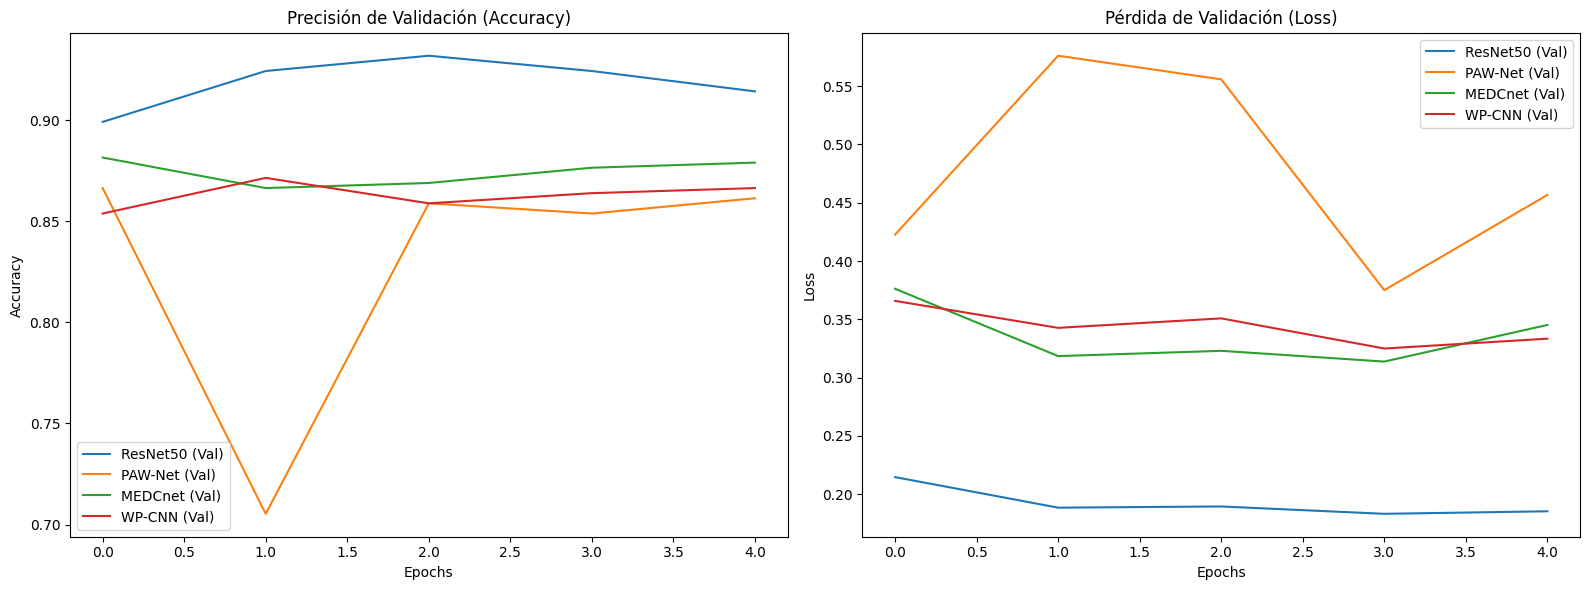

In [ ]:
def plot_learning_curves(histories, names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    for history, name in zip(histories, names):
        # Accuracy
        ax1.plot(history['val_acc'], label=f'{name} (Val)')
        ax1.set_title('Precisión de Validación (Accuracy)')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend()

        # Loss
        ax2.plot(history['val_loss'], label=f'{name} (Val)')
        ax2.set_title('Pérdida de Validación (Loss)')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend()

    plt.tight_layout()
    plt.show()

# Llamar a la función con tus historiales
#histories = [pawnet_history, medcnet_history, wpcnn_history]
#names = [ "PAW-Net", "MEDCnet", "WP-CNN"]
histories = [resnet_history, pawnet_history, medcnet_history, wpcnn_history]
names = ["ResNet50", "PAW-Net", "MEDCnet", "WP-CNN"]
plot_learning_curves(histories, names)

**Matriz de confusion**

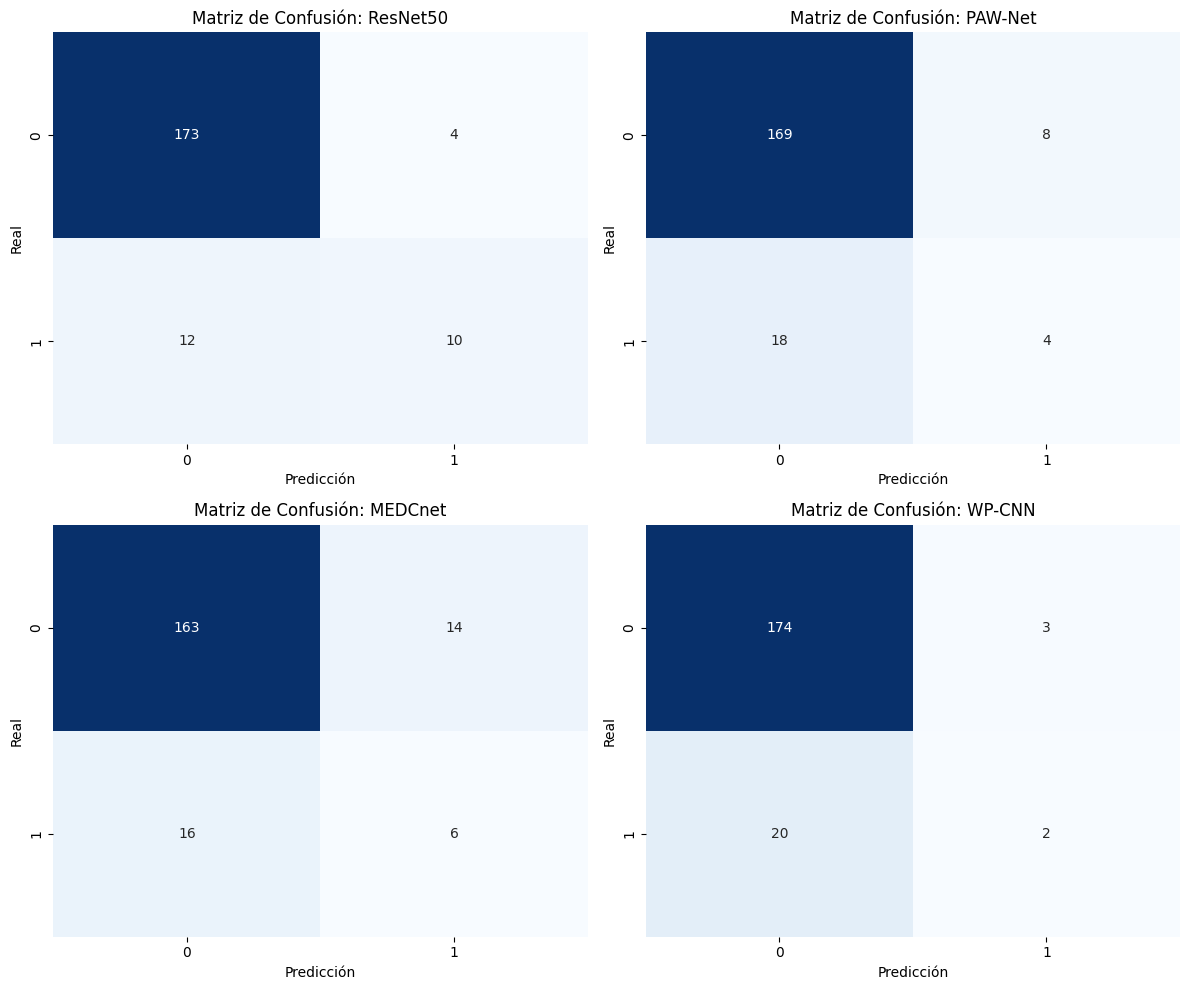

In [ ]:
def plot_confusion_matrices(all_model_preds, y_true, names):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for i, name in enumerate(names):
        cm = confusion_matrix(y_true, all_model_preds[name])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues', cbar=False)
        axes[i].set_title(f'Matriz de Confusión: {name}')
        axes[i].set_xlabel('Predicción')
        axes[i].set_ylabel('Real')

    plt.tight_layout()
    plt.show()

# Usamos las etiquetas del último modelo evaluado (son las mismas para todos)
plot_confusion_matrices(all_model_preds, labels, names)

Matriz de Correlación de Predicciones

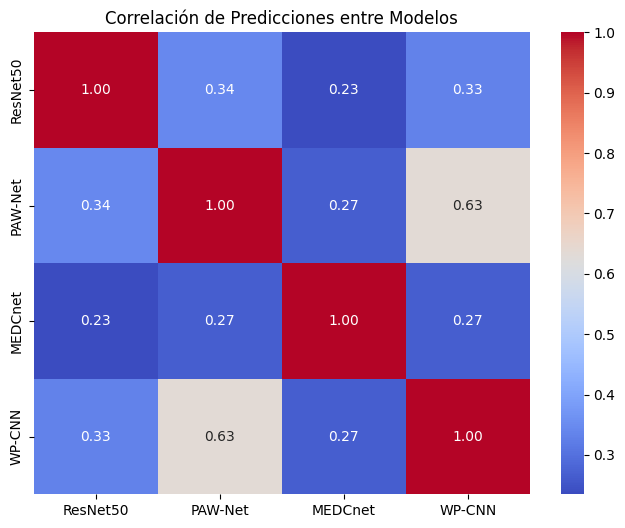

In [ ]:
# Crear un dataframe con las predicciones de todos los modelos
df_preds = pd.DataFrame(all_model_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(df_preds.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación de Predicciones entre Modelos')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1. Función para recolectar TODO en un solo paso
def get_full_metrics(model, dataloader, name):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    # --- Medir Tiempo de Inferencia ---
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        for _ in range(10): _ = model(dummy_input) # Warm-up
        start_time = time.time()
        for _ in range(100): _ = model(dummy_input)
        inference_time = (time.time() - start_time) / 100 * 1000 # en ms

    # --- Evaluación de Desempeño ---
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    # Métricas Médicas y Técnicas
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    # Cálculo de parámetros y tamaño
    total_params = sum(p.numel() for p in model.parameters()) / 1e6 # en Millones
    torch.save(model.state_dict(), "temp.p")
    model_size = os.path.getsize("temp.p") / (1024 * 1024) # en MB
    os.remove("temp.p")

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    return {
        'Modelo': name,
        'Accuracy': (tp + tn) / (tp + tn + fp + fn),
        'Sensibilidad (Recall)': tp / (tp + fn),
        'Especificidad': tn / (tn + fp),
        'AUC': roc_auc,
        'Inferencia (ms)': inference_time,
        'Tamaño (MB)': model_size,
        'Parámetros (M)': total_params
    }

# 2. Ejecutar comparativa
list_of_models = [
    (model_resnet, "ResNet50"),
    (model_pawnet, "PAW-Net"),
    (model_medcnet, "MEDCnet"),
    (model_wpcnn, "WP-CNN")
]

final_results = []
for model, name in list_of_models:
    print(f"Analizando {name}...")
    final_results.append(get_full_metrics(model, dataloaders['test'], name))

df_final = pd.DataFrame(final_results)

# --- Visualización de Resultados ---
print("\n### TABLA COMPARATIVA FINAL DE INGENIERÍA ###")
print(df_final.sort_values(by='Accuracy', ascending=False))

Analizando ResNet50...
Analizando PAW-Net...
Analizando MEDCnet...
Analizando WP-CNN...

### TABLA COMPARATIVA FINAL DE INGENIERÍA ###
     Modelo  Accuracy  Sensibilidad (Recall)  Especificidad       AUC  \
0  ResNet50  0.919598               0.454545       0.977401  0.933744   
3    WP-CNN  0.884422               0.090909       0.983051  0.790447   
1   PAW-Net  0.869347               0.181818       0.954802  0.714689   
2   MEDCnet  0.849246               0.272727       0.920904  0.763482   

   Inferencia (ms)  Tamaño (MB)  Parámetros (M)  
0       223.171647    91.961337       24.033090  
3        43.687627    98.078403       25.709890  
1        21.064126     3.071397        0.804482  
2        22.813382     6.150283        1.611218  


In [ ]:
from sklearn.utils import resample

def bootstrap_confidence_interval(y_true, y_pred, metric_func, n_iterations=1000, alpha=0.95):
    stats = []
    for i in range(n_iterations):
        # remuestreo con reemplazo
        y_true_resample, y_pred_resample = resample(y_true, y_pred, random_state=i)
        statistic = metric_func(y_true_resample, y_pred_resample)
        stats.append(statistic)

    # Calcular el intervalo de confianza
    lower_bound = np.percentile(stats, ((1 - alpha) / 2) * 100)
    upper_bound = np.percentile(stats, (alpha + (1 - alpha) / 2) * 100)
    return lower_bound, upper_bound

print("### Intervalos de Confianza (95%) para la Precisión (Accuracy) ###")
for model_name, preds in all_model_preds.items():
    lower, upper = bootstrap_confidence_interval(labels, preds, accuracy_score)
    print(f"{model_name}: ({lower:.4f}, {upper:.4f})")

### Intervalos de Confianza (95%) para la Precisión (Accuracy) ###
ResNet50: (0.8794, 0.9548)
PAW-Net: (0.8191, 0.9097)
MEDCnet: (0.7990, 0.8995)
WP-CNN: (0.8392, 0.9296)
